first ```conda install -c conda-forge rioxarray```

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
#import rioxarray as rxr
from rasterio.windows import Window
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import xarray as xr

### 2018 NAIP ###

In [2]:
filepath = '/home/jovyan/UrbanForest'
infile = os.path.join(filepath, 'santa_monica_4bandNAIP_mosaic_originwarp_1m.tiff')

Load data and get the profile

In [3]:
with rio.open(infile, 'r') as src:
    profile = src.profile
    data = src.read()
profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 11946, 'height': 14334, 'count': 4, 'crs': CRS.from_epsg(26911), 'transform': Affine(1.0, 0.0, 355548.0,
       0.0, -1.0, 3770340.0), 'tiled': False, 'interleave': 'pixel'}

In [37]:
data.shape

(4, 14334, 11946)

In [38]:
#!gdalinfo /home/jovyan/UrbanForest/santa_monica_4bandNAIP_mosaic_originwarp_1m.tiff

gdalinfo gives us:
```
Band 1 Block=11946x1 Type=Byte, ColorInterp=Red
Band 2 Block=11946x1 Type=Byte, ColorInterp=Green
Band 3 Block=11946x1 Type=Byte, ColorInterp=Blue
Band 4 Block=11946x1 Type=Byte, ColorInterp=Undefined
```

In this case 4 is near IR.

Easier to teal with things in an xarray.

In [5]:
xdata = xr.DataArray(data)
xdata= xdata.where(data != np.inf)

Calculate NDVI, fill the no value spots with -9

In [18]:
ndvi = es.normalized_diff(xdata[3], xdata[0])
ndvi = ndvi.filled(-9)

Plot the NDVI.

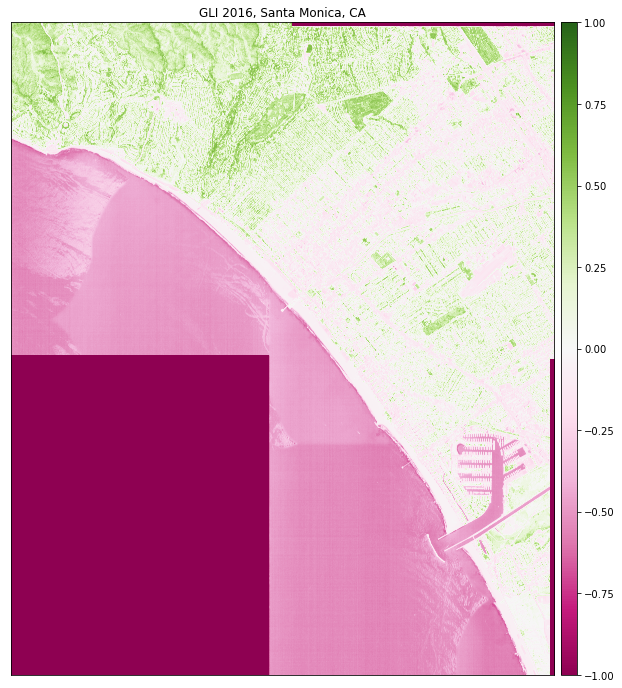

In [21]:
ep.plot_bands(ndvi, cmap='PiYG', scale=False, vmin=-1, vmax=1, title='NDVI 2018, Santa Monica +, CA');

Examine histogram to determine a good cuttoff value for the mask.

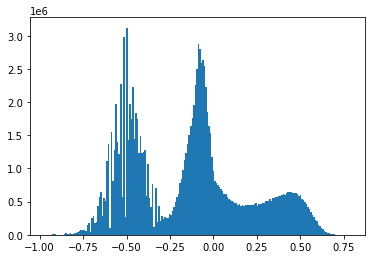

In [19]:
import matplotlib.pyplot as plt
ax = plt.hist(ndvi[ndvi > -8], bins=200);

It looks like the bottom bump is water, the middle bump is built environment and the upper bumb is vegetation.  Lets use 0.25 as a cuttoff for masking. the CHM.  But first we will write a geotiff of ndvi.

In [25]:
thresh = 0.25
mask = ndvi > thresh
rio.dtypes.can_cast_dtype(mask, 'uint8')

True

In [33]:
mask_file = f'mask_{str(thresh)}.tif'
profile['count'] = 1
mask = mask.reshape(1, 14334, 11946)

with rio.open(mask_file, 'w', **profile) as dst:
    dst.write(mask.astype(rio.uint8))

In [36]:
outfile = 'santa_monica_4bandNAIP_mosaic_originwarp_1m_ndvi.tif'
infile = f'{filepath}/santa_monica_mosaic_35mlimit_originwarp.tiff'

with rio.open(mask_file, 'r') as mask:
    with rio.open(infile, 'r') as src:
        # you need the extent polygon or to grop the NAIp first
        print(type(mask.read() * src.read()))

ValueError: operands could not be broadcast together with shapes (1,14334,11946) (1,6241,6900) 